# **Sentiment Analysis for Investment Strategies on Tesla Stock**

# 2. Sentiment Analysis of News and Impact on Tesla Stock
Data in the past 30 days (from **2023-9-12** to **2023-10-11**) has been collected in the previous step from APIs.

A pre-trained transformer model is utilized to perform sentiment analysis on all news related to Tesla.
* [FinBERT](https://huggingface.co/ProsusAI/finbert): developed for financial sentiment analysis with BERT
* The model provides two outputs: label and confidence score. Labels are positive, negative and neutral. Confidence socres vary from 0 to 1.

After sentiment analysis, correlation between the news sentiments and Tesla stock is investigated for potential short-term (days or weeks) investment strategies.

## 2.1. Import Libarires

In [2]:
import torch
torch.__version__

'1.12.1'

In [40]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

## 2.2. Sentiment Analysis on News

### 2.2.1. Load Pre-trained Model

In [4]:
# choose finbert model which is a pre-trained LL model to analyze sentiment of financial text
model_name = "ProsusAI/finbert"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

**Note:** It requires some time to load the model if loading for the first time.

### 2.2.2. Sentiment Analysis on Text Samples

In [5]:
# play with the encode and decode
tokens = tokenizer.encode('Tesla just launched its first self-driving car!', return_tensors = 'pt')
tokens

tensor([[  101, 26060,  2074,  3390,  2049,  2034,  2969,  1011,  4439,  2482,
           999,   102]])

In [6]:
type(tokens)

torch.Tensor

In [7]:
tokenizer.decode(tokens[0])

'[CLS] tesla just launched its first self - driving car! [SEP]'

In [8]:
# create a pipeline for sentiment analysis
sent_ana = pipeline('sentiment-analysis', model = model, tokenizer = tokenizer)

In [9]:
# test 1
text = 'Tesla just launched its first self-driving car!'

result = sent_ana(text)
result

[{'label': 'neutral', 'score': 0.8160327672958374}]

In [10]:
# test 2
text = 'Tesla just successfully launched its first self-driving car!'

result = sent_ana(text)
result

[{'label': 'positive', 'score': 0.5273283123970032}]

In [11]:
# test 3
text = 'Tesla failed to launch its first self-driving car!'

result = sent_ana(text)
result

[{'label': 'negative', 'score': 0.5945389270782471}]

**Note:** The loaded model works as epxected.

### 2.2.3. Sentiment Analysis on Tesla News

In [115]:
# load news
df_news = pd.read_csv('../data/Tesla_news.csv')
df_news.head()

,source_name,author,date,title,description,content
0,The Jerusalem Post,By REUTERS,2023-09-12,Putin hails Elon Musk as an 'outstanding perso...,The Russian leader said Moscow planned to pers...,Russian President Vladimir Putin on Tuesday ha...
1,Business Insider,ssheth@businessinsider.com (Sonam Sheth),2023-09-12,Elon Musk learned hypnosis as a child and mana...,Elon Musk learned magic tricks and hypnosis as...,"When Elon Musk was a kid, he learned hypnosis ..."
2,Fortune,Paige Hagy,2023-09-12,Elon Musk lives life like he’s playing a video...,"""Elon Musk,"" a biography that recounts the chi...",Elon Musk had just finished playing a video ga...
3,CNN,Paul Glader,2023-09-12,Four takeaways from Walter Isaacson's biograph...,"""You'll never be successful,"" Errol Musk in 19...","Youll never be successful, Errol Musk in 1989 ..."
4,Business Insider,"Grace Kay,Grace Dean",2023-09-12,Elon Musk 'associates love with being mean or ...,"""When we hang out, I make sure I'm with the ri...","Grimes told Walter Isaacson that Elon Musk ""as..."


There are 3 text features for each news, `title`, `content` and `description`.

Let check if the sentiment analysis is consistent for the 3 features above.

In [117]:
# define a function for sentiment analysis
def sentiment_results(df, target_cols):
    for item in target_cols:
        new_label = item + '_label'
        new_score = item + '_score'
        # perform sentiment analysis for each entry and store the label and the score
        for i in range(df.shape[0]):
            try:
                result = sent_ana(df.loc[i, item])
                df.loc[i, new_label] = result[0]['label']
                df.loc[i, new_score] = result[0]['score']
            except:
                print('The {}th row in {} column raised error.'.format(i, item))
    return df

In [118]:
# get sentiment analysis results for title first
target_cols = ['title', 'content', 'description']
df_news_sa = sentiment_results(df_news, target_cols)
df_news_sa.head()

,source_name,author,date,title,description,content,title_label,title_score,content_label,content_score,description_label,description_score
0,The Jerusalem Post,By REUTERS,2023-09-12,Putin hails Elon Musk as an 'outstanding perso...,The Russian leader said Moscow planned to pers...,Russian President Vladimir Putin on Tuesday ha...,positive,0.680616,positive,0.816032,positive,0.886540
1,Business Insider,ssheth@businessinsider.com (Sonam Sheth),2023-09-12,Elon Musk learned hypnosis as a child and mana...,Elon Musk learned magic tricks and hypnosis as...,"When Elon Musk was a kid, he learned hypnosis ...",neutral,0.918148,neutral,0.933047,neutral,0.924242
2,Fortune,Paige Hagy,2023-09-12,Elon Musk lives life like he’s playing a video...,"""Elon Musk,"" a biography that recounts the chi...",Elon Musk had just finished playing a video ga...,neutral,0.929564,neutral,0.932324,neutral,0.886649
3,CNN,Paul Glader,2023-09-12,Four takeaways from Walter Isaacson's biograph...,"""You'll never be successful,"" Errol Musk in 19...","Youll never be successful, Errol Musk in 1989 ...",neutral,0.925487,neutral,0.881693,neutral,0.647073
4,Business Insider,"Grace Kay,Grace Dean",2023-09-12,Elon Musk 'associates love with being mean or ...,"""When we hang out, I make sure I'm with the ri...","Grimes told Walter Isaacson that Elon Musk ""as...",neutral,0.561624,neutral,0.555736,neutral,0.782567


In [119]:
# check for missing data
df_news_sa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source_name        423 non-null    object 
 1   author             419 non-null    object 
 2   date               423 non-null    object 
 3   title              423 non-null    object 
 4   description        423 non-null    object 
 5   content            423 non-null    object 
 6   title_label        423 non-null    object 
 7   title_score        423 non-null    float64
 8   content_label      423 non-null    object 
 9   content_score      423 non-null    float64
 10  description_label  423 non-null    object 
 11  description_score  423 non-null    float64
dtypes: float64(3), object(9)
memory usage: 39.8+ KB


In [120]:
# since the sentiment analysis takes quite some time to run, better to save out the raw sentiment analysis outputs
df_news_sa.to_csv('../data/Tesla_sentiment_results.csv', index = False)

In [50]:
# load in sentiment analysis results
df_sa = pd.read_csv('../data/Tesla_sentiment_results.csv')
df_sa.head()

,source_name,author,date,title,description,content,title_label,title_score,content_label,content_score,description_label,description_score
0,The Jerusalem Post,By REUTERS,2023-09-12,Putin hails Elon Musk as an 'outstanding perso...,The Russian leader said Moscow planned to pers...,Russian President Vladimir Putin on Tuesday ha...,positive,0.680616,positive,0.816032,positive,0.886540
1,Business Insider,ssheth@businessinsider.com (Sonam Sheth),2023-09-12,Elon Musk learned hypnosis as a child and mana...,Elon Musk learned magic tricks and hypnosis as...,"When Elon Musk was a kid, he learned hypnosis ...",neutral,0.918148,neutral,0.933047,neutral,0.924242
2,Fortune,Paige Hagy,2023-09-12,Elon Musk lives life like he’s playing a video...,"""Elon Musk,"" a biography that recounts the chi...",Elon Musk had just finished playing a video ga...,neutral,0.929564,neutral,0.932324,neutral,0.886649
3,CNN,Paul Glader,2023-09-12,Four takeaways from Walter Isaacson's biograph...,"""You'll never be successful,"" Errol Musk in 19...","Youll never be successful, Errol Musk in 1989 ...",neutral,0.925487,neutral,0.881693,neutral,0.647073
4,Business Insider,"Grace Kay,Grace Dean",2023-09-12,Elon Musk 'associates love with being mean or ...,"""When we hang out, I make sure I'm with the ri...","Grimes told Walter Isaacson that Elon Musk ""as...",neutral,0.561624,neutral,0.555736,neutral,0.782567


In [51]:
# check the loaded dataframe for consistency
df_sa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source_name        423 non-null    object 
 1   author             419 non-null    object 
 2   date               423 non-null    object 
 3   title              423 non-null    object 
 4   description        423 non-null    object 
 5   content            423 non-null    object 
 6   title_label        423 non-null    object 
 7   title_score        423 non-null    float64
 8   content_label      423 non-null    object 
 9   content_score      423 non-null    float64
 10  description_label  423 non-null    object 
 11  description_score  423 non-null    float64
dtypes: float64(3), object(9)
memory usage: 39.8+ KB


In [52]:
# drop results with low scores < 0.5
print('Before dropping: {} rows.'.format(df_sa.shape[0]))
df_sa = df_sa[df_sa['content_score'] >= 0.5]
print('After dropping: {} rows.'.format(df_sa.shape[0]))

Before dropping: 423 rows.
After dropping: 410 rows.


In [53]:
# let check data with inconsistent sentiment labels for title and content
df_sa[df_sa['title_label'] != df_sa['content_label']].shape[0]

119

In [54]:
# let check data with inconsistent sentiment labels for title and content
df_sa[df_sa['title_label'] != df_sa['description_label']].shape[0]

137

In [55]:
# let check data with inconsistent sentiment labels for title and content
df_sa[df_sa['description_label'] != df_sa['content_label']].shape[0]

134

In [56]:
# let check data with inconsistent sentiment labels for all
df_sa[(df_sa['description_label'] != df_sa['content_label']) & (df_sa['content_label'] != df_sa['title_label']) & (df_sa['description_label'] != df_sa['title_label'])].shape[0]

12

In [57]:
df_sa[(df_sa['description_label'] != df_sa['content_label']) & (df_sa['content_label'] != df_sa['title_label']) & (df_sa['description_label'] != df_sa['title_label'])].head(20)

,source_name,author,date,title,description,content,title_label,title_score,content_label,content_score,description_label,description_score
10,Financial Post,Bloomberg News,2023-09-12,Tesla gets $80-billion boost from analyst call...,Some investors find Tesla Inc.'s $500-billion ...,Some investors find the $500-billion projectio...,positive,0.771905,negative,0.776972,neutral,0.501461
30,BBC News,NaN,2023-09-13,"'Overwhelming consensus' to regulate AI, says ...",The Tesla CEO was among the top tech leaders m...,"Top tech leaders, including Elon Musk, Mark Zu...",positive,0.835616,negative,0.858609,neutral,0.859004
40,Business Insider,Phil Rosen,2023-09-13,Tesla is the most shorted stock in the market ...,Elon Musk's EV maker topped the list of most s...,Tesla CEO Elon Musk.Yichuan Cao/NurPhoto via G...,neutral,0.750265,negative,0.869421,positive,0.918394
48,Business Insider,Phil Rosen,2023-09-13,Tesla is the most shorted stock in the market ...,Elon Musk's EV maker topped the list of most s...,Tesla CEO Elon Musk.Yichuan Cao/NurPhoto via G...,neutral,0.750265,negative,0.869421,positive,0.918394
51,BBC News,NaN,2023-09-13,"'Overwhelming consensus' to regulate AI, says ...",The Tesla CEO was among the top tech leaders m...,"Top tech leaders, including Elon Musk, Mark Zu...",positive,0.835616,negative,0.858609,neutral,0.859004
63,The Times of India,Bloomberg,2023-09-13,Tesla got an $80 billion boost from analyst ca...,"Meanwhile, Tesla is still working on developin...",This may sound familiar: Morgan Stanley analys...,positive,0.508441,neutral,0.909839,negative,0.793720
206,The Jerusalem Post,By ZVIKA KLEIN,2023-09-20,ADL CEO: Thankful for Netanyahu asking Musk to...,"Earlier this month, X owner Elon Musk threaten...",Anti Defamation League CEO Jonathan Greenblatt...,neutral,0.759574,positive,0.828075,negative,0.779976
213,The Times of India,New York Times,2023-09-21,"For Tesla and Musk, auto strike carries benefi...","Unencumbered by an activist union, Tesla can t...",The United Auto Workers strike against the Mic...,neutral,0.713570,negative,0.875432,positive,0.445533
223,Fortune,Will Daniel,2023-09-22,Benjamin Netanyahu fears AI could ‘cannibalize...,The pace of AI development “is outpacing what ...,Israeli Prime Minister Benjamin Netanyahu sat ...,negative,0.825325,neutral,0.904046,positive,0.465632
236,CNN,"Michelle Toh, Carina Cheng",2023-09-25,'Where is the phone?' Huawei keeps quiet about...,Huawei has disappointed legions of fans — and ...,Editors Note: Sign up for CNNs Meanwhile in Ch...,neutral,0.903829,negative,0.926851,positive,0.499964


**Note:** There are some difference in sentiment results for `title`, `content` and `description`.

In [58]:
# check data with different sentiment results for title and content
df_sa[df_sa['title_label'] != df_sa['content_label']].head()

,source_name,author,date,title,description,content,title_label,title_score,content_label,content_score,description_label,description_score
10,Financial Post,Bloomberg News,2023-09-12,Tesla gets $80-billion boost from analyst call...,Some investors find Tesla Inc.'s $500-billion ...,Some investors find the $500-billion projectio...,positive,0.771905,negative,0.776972,neutral,0.501461
19,Fortune,Jane Thier,2023-09-12,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Google’s acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,negative,0.763145,neutral,0.633973,negative,0.595663
22,Next Big Future,Brian Wang,2023-09-12,Bill Gates Tries to Profit by Driving Down Tes...,Bill Gates bet billions against Tesla in a met...,Bill Gates bet billions against Tesla in a met...,negative,0.664616,neutral,0.916204,neutral,0.889956
28,Next Big Future,Brian Wang,2023-09-13,Tesla Semi Crushing Freightliner eCascadia and...,The Run on Less Event is testing electric semi...,The Run on Less Event is testing electric semi...,neutral,0.864688,positive,0.545643,neutral,0.605880
30,BBC News,NaN,2023-09-13,"'Overwhelming consensus' to regulate AI, says ...",The Tesla CEO was among the top tech leaders m...,"Top tech leaders, including Elon Musk, Mark Zu...",positive,0.835616,negative,0.858609,neutral,0.859004


In [59]:
# check some examples
row = 30
print('Title: ' + df_sa.loc[row, 'title'] + '\nLabel: ' + df_sa.loc[row, 'title_label'] + '\nScore: ' + str(df_sa.loc[row, 'title_score']))
print('---------------------------------------------------------------------------------------------------------------------------------------')
print('Content: ' + df_sa.loc[row, 'content'] + '\nLabel: ' + df_sa.loc[row, 'content_label'] + '\nScore: ' + str(df_sa.loc[row, 'content_score']))
print('---------------------------------------------------------------------------------------------------------------------------------------')
print('Description: ' + df_sa.loc[row, 'description'] + '\nLabel: ' + df_sa.loc[row, 'description_label'] + '\nScore: ' + str(df_sa.loc[row, 'description_score']))

Title: 'Overwhelming consensus' to regulate AI, says Elon Musk
Label: positive
Score: 0.8356161713600159
---------------------------------------------------------------------------------------------------------------------------------------
Content: Top tech leaders, including Elon Musk, Mark Zuckerberg, Sundar Pichai and Bill Gates, met US lawmakers on Wednesday to discuss AI governance.
'This meeting may go down in history as being very impor… [+47 chars]
Label: negative
Score: 0.8586087822914124
---------------------------------------------------------------------------------------------------------------------------------------
Description: The Tesla CEO was among the top tech leaders meeting with US lawmakers to discuss AI governance
Label: neutral
Score: 0.8590039014816284


**Note:** After checking some examples with inconsistent labels for `title`, `content` and `description`, the following methods are proposed to creating a single sentiment label for each news article. 
* Option 1: Choose the one with the highest score.
* Option 2: Use `content_label` since it has the most context for sentiment analysis.
* Option 3: Use `title_label` since people might just read about title instead of reading the whole thing.

### 2.2.4. Sentiment Analysis EDA

In [60]:
# create the label based on option 1
# create a function to get the label with the highest score for each row in the dataframe
def get_high_score_label(row):
    labels = ['title_label', 'content_label', 'description_label']
    scores = [row['title_score'], row['content_score'], row['description_score']]
    i_high = scores.index(max(scores))
    return row[labels[i_high]]
    
df_sa['label_opt1'] = df_sa.apply(get_high_score_label, axis = 1)
df_sa[df_sa['title_label'] != df_sa['content_label']].head()

,source_name,author,date,title,description,content,title_label,title_score,content_label,content_score,description_label,description_score,label_opt1
10,Financial Post,Bloomberg News,2023-09-12,Tesla gets $80-billion boost from analyst call...,Some investors find Tesla Inc.'s $500-billion ...,Some investors find the $500-billion projectio...,positive,0.771905,negative,0.776972,neutral,0.501461,negative
19,Fortune,Jane Thier,2023-09-12,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Google’s acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,negative,0.763145,neutral,0.633973,negative,0.595663,negative
22,Next Big Future,Brian Wang,2023-09-12,Bill Gates Tries to Profit by Driving Down Tes...,Bill Gates bet billions against Tesla in a met...,Bill Gates bet billions against Tesla in a met...,negative,0.664616,neutral,0.916204,neutral,0.889956,neutral
28,Next Big Future,Brian Wang,2023-09-13,Tesla Semi Crushing Freightliner eCascadia and...,The Run on Less Event is testing electric semi...,The Run on Less Event is testing electric semi...,neutral,0.864688,positive,0.545643,neutral,0.605880,neutral
30,BBC News,NaN,2023-09-13,"'Overwhelming consensus' to regulate AI, says ...",The Tesla CEO was among the top tech leaders m...,"Top tech leaders, including Elon Musk, Mark Zu...",positive,0.835616,negative,0.858609,neutral,0.859004,neutral


In [63]:
# drop text in the dataframe
df_label = df_sa.drop(labels = ['title', 'author', 'description', 'content', 'title_score', 'content_score', 'description_score'], axis = 1)
df_label.head()

,source_name,date,title_label,content_label,description_label,label_opt1
0,The Jerusalem Post,2023-09-12,positive,positive,positive,positive
1,Business Insider,2023-09-12,neutral,neutral,neutral,neutral
2,Fortune,2023-09-12,neutral,neutral,neutral,neutral
3,CNN,2023-09-12,neutral,neutral,neutral,neutral
4,Business Insider,2023-09-12,neutral,neutral,neutral,neutral


In [112]:
# save the output
df_label.info()
df_label.to_csv('../data/Tesla_sentiment_labels.csv', index = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410 entries, 0 to 422
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   source_name        410 non-null    object
 1   date               410 non-null    object
 2   title_label        410 non-null    object
 3   content_label      410 non-null    object
 4   description_label  410 non-null    object
 5   label_opt1         410 non-null    object
dtypes: object(6)
memory usage: 38.6+ KB


In [15]:
# readin the output
df_label = pd.read_csv('../data/Tesla_sentiment_labels.csv')
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   source_name        410 non-null    object
 1   date               410 non-null    object
 2   title_label        410 non-null    object
 3   content_label      410 non-null    object
 4   description_label  410 non-null    object
 5   label_opt1         410 non-null    object
dtypes: object(6)
memory usage: 19.3+ KB


In [3]:
# let def a function to plot total number each label daily
def plot_daily_sents(label_col):
    count = df_label.groupby('date')[label_col].value_counts(normalize = True) * 100
    count.name = 'value'
    count = count.reset_index()

    plt.figure(figsize = (16, 8))
    sns.barplot(data = count, x = 'date', y = 'value', hue = label_col)
    plt.xticks(rotation = 90)
    plt.title('News Sentiment Analysis based on '+ label_col +' Label', fontsize = 18, pad = 10)
    plt.xlabel('Date', fontsize = 16)
    plt.ylabel('Percentage', fontsize = 16)
    plt.legend(loc = 'upper center')
    plt.show()

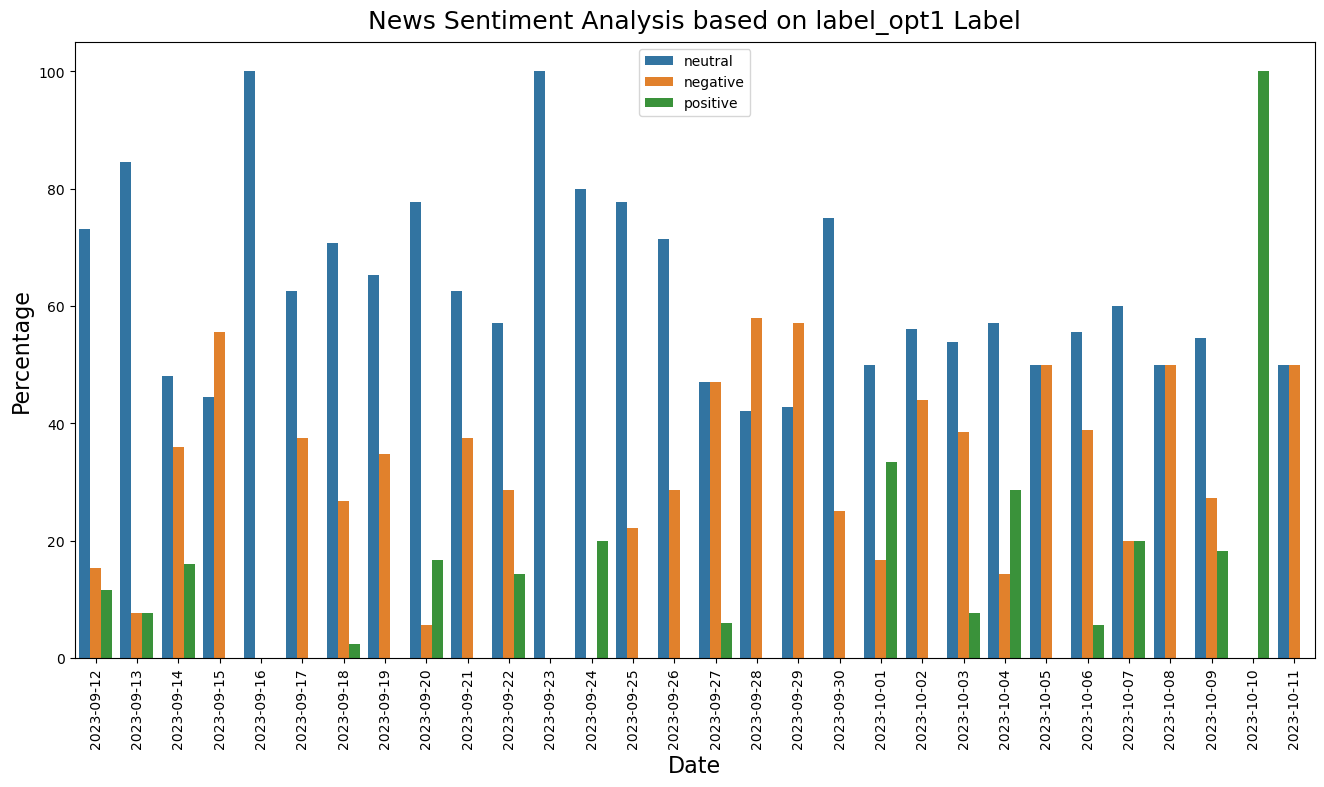

In [4]:
# plot daily sentiments using option 1 label (high score)
plot_daily_sents('label_opt1')

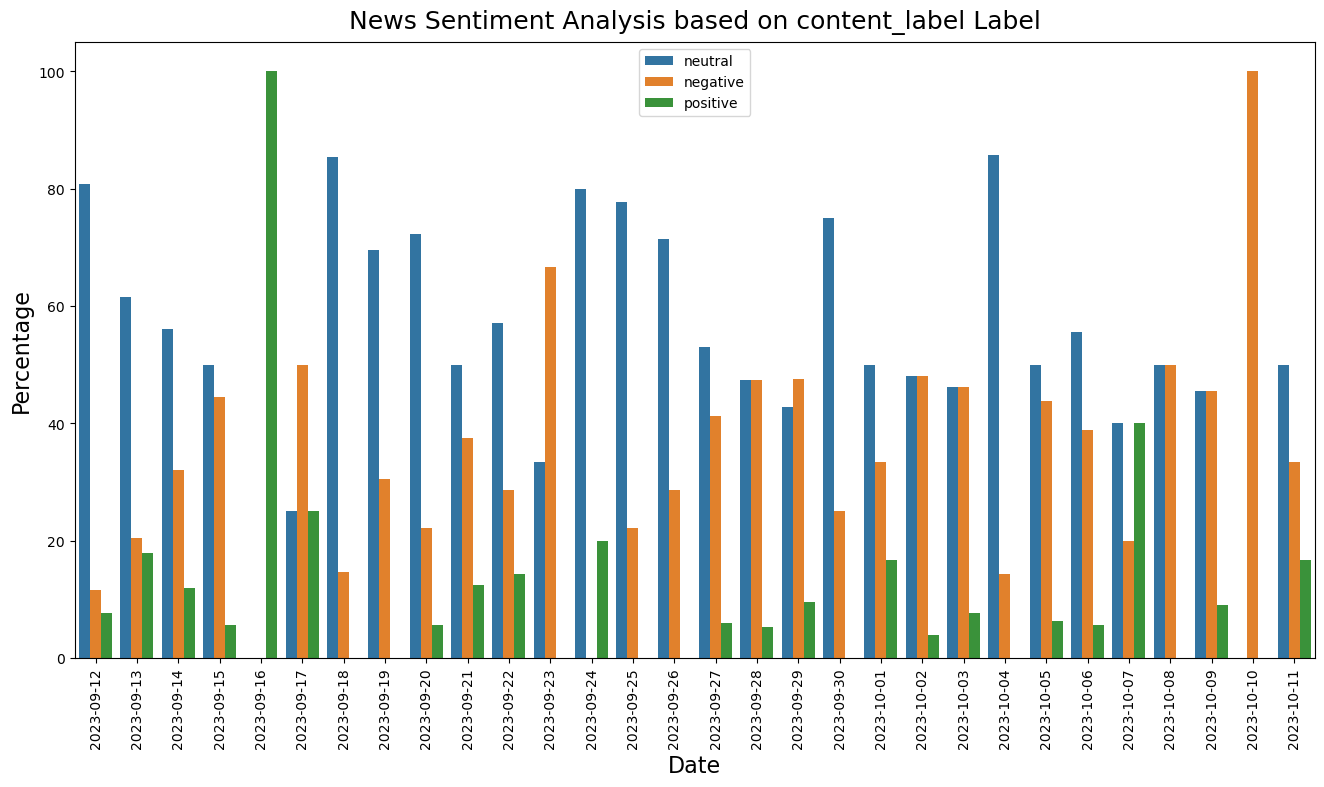

In [5]:
# plot daily sentiments using option 2 label (content)
plot_daily_sents('content_label')

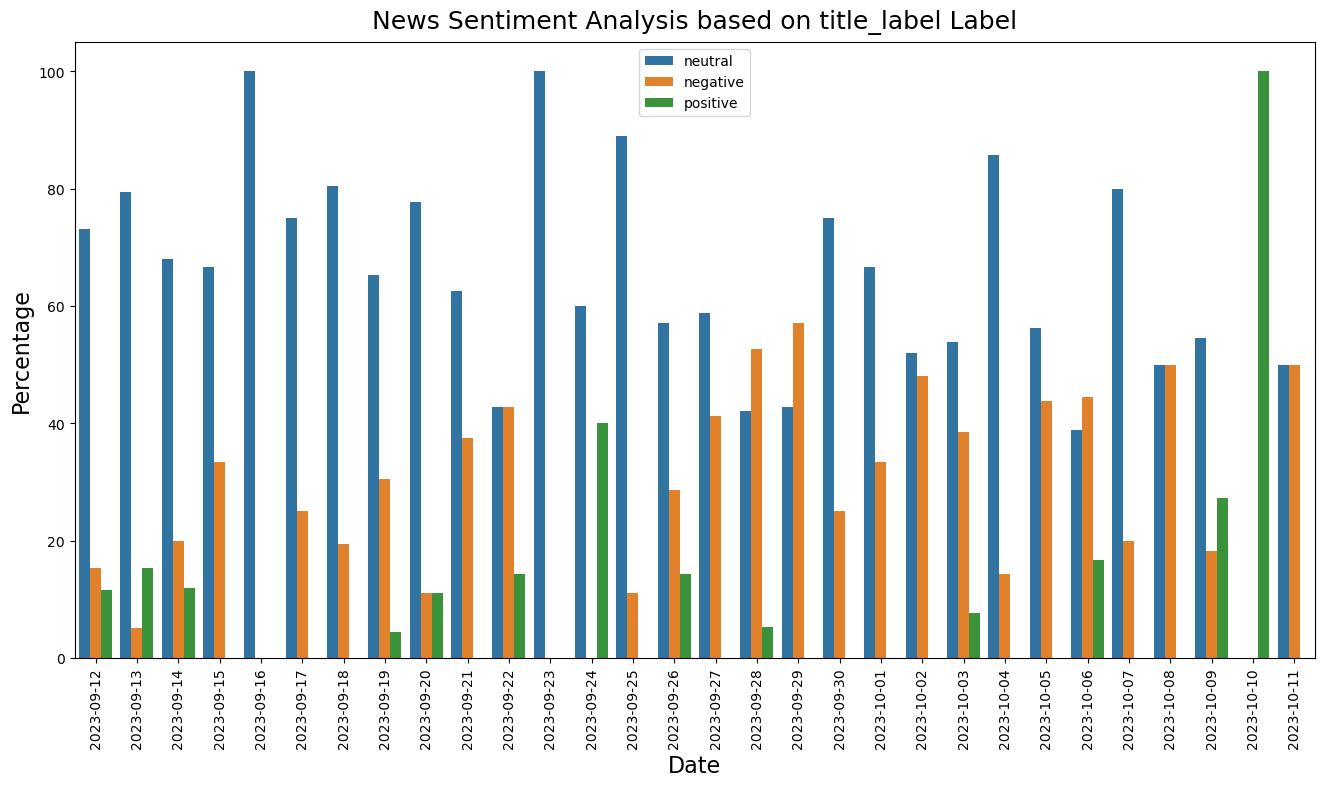

In [6]:
# plot daily sentiments using option 3 label (title)
plot_daily_sents('title_label')

**Note:**
* News articles on Tesla in the past 30 days are dominated by neutral ones.
* The public media tends to reports more negative news about Tesla compared to positive ones.
* Title label distribution is overall consistent with high-score label.
* Content label distribution is somehow different from the other two.

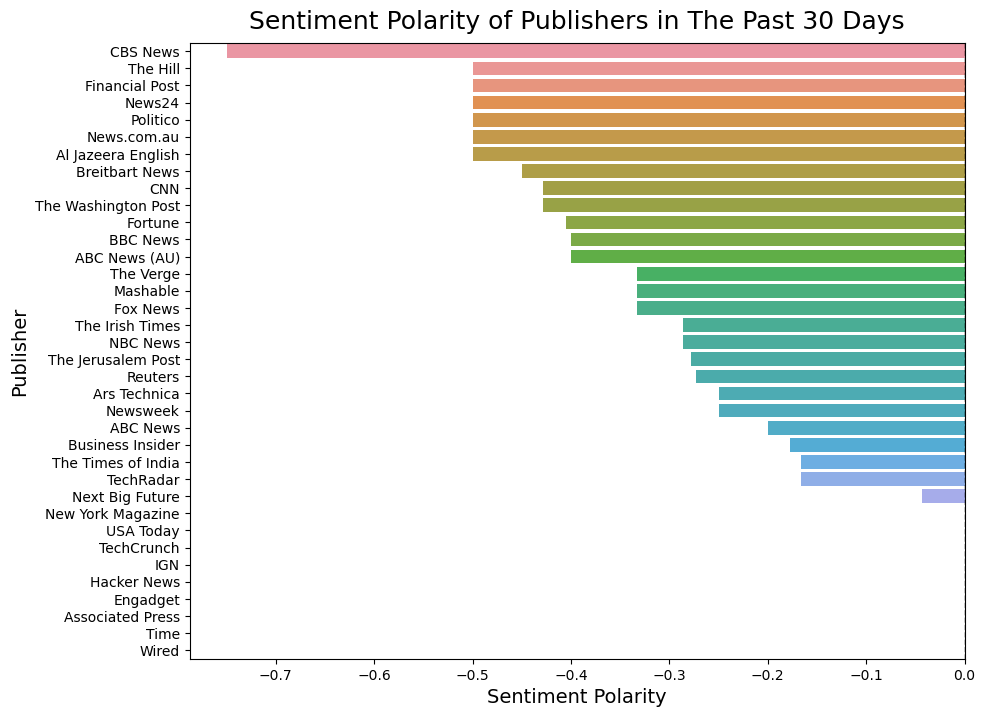

In [141]:
# EDA based on publisher
# show positive rate - negative rate as sentiment polarity for each publisher
count1 = pd.DataFrame(df_label.groupby('source_name')['label_opt1'].apply(lambda x: x[x =='negative'].count() / x.count()).reset_index())
count2 = pd.DataFrame(df_label.groupby('source_name')['label_opt1'].apply(lambda x: x[x =='positive'].count() / x.count()).reset_index())
count3 = pd.merge(count1, count2, on = 'source_name', how = 'left')
count3['polarity'] = count3['label_opt1_y'] - count3['label_opt1_x']
count3 = count3.sort_values(by = ['polarity'], ascending = True)

plt.figure(figsize = (10, 8))
sns.barplot(data = count3, y = 'source_name', x = 'polarity')
plt.axvline(x = 0, color = 'k', linestyle = '--', linewidth = 1)

plt.title('Sentiment Polarity of Publishers in The Past 30 Days', fontsize = 18, pad = 10)
plt.xlabel('Sentiment Polarity', fontsize = 14)
plt.ylabel('Publisher', fontsize = 14)

plt.show()

**Note:**
* All publishers reported more negative news about Tesla than positive ones in the past 30 days.
* CBS News shows the worst sentiment polarity which reported much more negative news than positive ones for Tesla. 
* However, the domiant type of news should be neutrual ones.

## 2.3. Sentiment Results vs Stock Price Movements

### 2.3.1. Create Sentiment Features

Now there are sentiment results of multiple articles for each day. 

Need to create some sentiment features for each day in order to investigating its impact on stock price's daily movements.

In [16]:
# create total number and rates for each label for each day
df_news_negr = pd.DataFrame(df_label.groupby('date')['label_opt1'].apply(lambda x: x[x =='negative'].count() / x.count()).reset_index())
df_news_posr = pd.DataFrame(df_label.groupby('date')['label_opt1'].apply(lambda x: x[x =='positive'].count() / x.count()).reset_index())
df_news_ntrr = pd.DataFrame(df_label.groupby('date')['label_opt1'].apply(lambda x: x[x =='neutral'].count() / x.count()).reset_index())
df_news_neg = pd.DataFrame(df_label.groupby('date')['label_opt1'].apply(lambda x: x[x =='negative'].count()).reset_index())
df_news_pos = pd.DataFrame(df_label.groupby('date')['label_opt1'].apply(lambda x: x[x =='positive'].count()).reset_index())
df_news_ntr = pd.DataFrame(df_label.groupby('date')['label_opt1'].apply(lambda x: x[x =='neutral'].count()).reset_index())
df_news_rates = pd.merge(df_news_pos, df_news_neg, on = 'date', how = 'inner')
df_news_rates = pd.merge(df_news_rates, df_news_ntr, on = 'date', how = 'inner')
df_news_rates = pd.merge(df_news_rates, df_news_posr, on = 'date', how = 'inner')
df_news_rates = pd.merge(df_news_rates, df_news_negr, on = 'date', how = 'inner')
df_news_rates = pd.merge(df_news_rates, df_news_ntrr, on = 'date', how = 'inner')
df_news_rates.columns = ['date', 'positive_num', 'negative_num', 'nuetral_num', 'positive_rate', 'negative_rate', 'neutral_rate']
df_news_rates['negative_rate'] = 0 - df_news_rates['negative_rate']
df_news_rates.head()

C:\Users\wfei2\AppData\Local\Temp\ipykernel_21656\1754797170.py:10: FutureWarning: Passing 'suffixes' which cause duplicate columns {'label_opt1_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_news_rates = pd.merge(df_news_rates, df_news_posr, on = 'date', how = 'inner')
C:\Users\wfei2\AppData\Local\Temp\ipykernel_21656\1754797170.py:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'label_opt1_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_news_rates = pd.merge(df_news_rates, df_news_ntrr, on = 'date', how = 'inner')


,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate
0,2023-09-12,3,4,19,0.115385,-0.153846,0.730769
1,2023-09-13,3,3,33,0.076923,-0.076923,0.846154
2,2023-09-14,4,9,12,0.160000,-0.360000,0.480000
3,2023-09-15,0,10,8,0.000000,-0.555556,0.444444
4,2023-09-16,0,0,2,0.000000,0.000000,1.000000


**Note:** The date is continous.

In [17]:
# get period of interest
period_days = 30

In [135]:
# check if need to fillin dates
days_in_data = int(str(df_news_rates['date'].max() - df_news_rates['date'].min()).split()[0]) + 1

if days_in_data < period_days:
    print('Need to fillin dates.')
    # fillin missing dates
    end_day = datetime.now().date() - timedelta(days = 1)
    print(end_day)
    start_day = end_day - timedelta(days = period_days - 1)
    print(start_day)

    all_days = pd.date_range(start=str(start_day), end = str(end_day))
    df_alldates = pd.DataFrame(all_days, columns = ['date'])

    df_news_rates['date'] = pd.to_datetime(df_news_rates['date'])

    df_news_rates = pd.merge(df_alldates, df_news_rates, on = 'date', how = 'left')
elif days_in_data > period_days:
    raise Exception('Error: The extracted news data have more dates than required.')

### 2.3.2. Stock Market Data Wrangling

In [18]:
# read in stock data
df_stock = pd.read_csv('../data/Tesla_stock.csv')
df_stock.head()

,date,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,datetime,inday_move,yesterday_move
0,2023-08-30,254.200,260.5100,250.59,256.90,121988437.0,260.5100,250.59,256.90,254.200,121988437.0,1.0,0.0,TSLA,XNAS,2023-08-30 00:00:00+00:00,2.700,NaN
1,2023-08-31,255.980,261.1800,255.05,258.08,108861698.0,261.1800,255.05,258.08,255.980,108861698.0,1.0,0.0,TSLA,XNAS,2023-08-31 00:00:00+00:00,2.100,1.18
2,2023-09-01,257.260,259.0794,242.01,245.01,132541640.0,259.0794,242.01,245.01,257.260,132541640.0,1.0,0.0,TSLA,XNAS,2023-09-01 00:00:00+00:00,-12.250,-13.07
3,2023-09-05,245.000,258.0000,244.86,256.49,129469565.0,258.0000,244.86,256.49,245.000,129469565.0,1.0,0.0,TSLA,XNAS,2023-09-05 00:00:00+00:00,11.490,11.48
4,2023-09-06,255.135,255.3900,245.06,251.92,116959759.0,255.3900,245.06,251.92,255.135,116959759.0,1.0,0.0,TSLA,XNAS,2023-09-06 00:00:00+00:00,-3.215,-4.57


In [19]:
# check data
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            30 non-null     object 
 1   open            30 non-null     float64
 2   high            30 non-null     float64
 3   low             30 non-null     float64
 4   close           30 non-null     float64
 5   volume          30 non-null     float64
 6   adj_high        30 non-null     float64
 7   adj_low         30 non-null     float64
 8   adj_close       30 non-null     float64
 9   adj_open        30 non-null     float64
 10  adj_volume      30 non-null     float64
 11  split_factor    30 non-null     float64
 12  dividend        30 non-null     float64
 13  symbol          30 non-null     object 
 14  exchange        30 non-null     object 
 15  datetime        30 non-null     object 
 16  inday_move      30 non-null     float64
 17  yesterday_move  29 non-null     float

In [20]:
# combine the two dataframe
df_combine = pd.merge(df_news_rates, df_stock, on = 'date', how = 'left')
df_combine.head()

,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate,open,high,low,...,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,datetime,inday_move,yesterday_move
0,2023-09-12,3,4,19,0.115385,-0.153846,0.730769,270.76,278.3900,266.60,...,267.48,270.76,135999866.0,1.0,0.0,TSLA,XNAS,2023-09-12 00:00:00+00:00,-3.28,-6.10
1,2023-09-13,3,3,33,0.076923,-0.076923,0.846154,270.07,274.9800,268.10,...,271.30,270.07,111673737.0,1.0,0.0,TSLA,XNAS,2023-09-13 00:00:00+00:00,1.23,3.82
2,2023-09-14,4,9,12,0.160000,-0.360000,0.480000,271.32,276.7094,270.42,...,276.04,271.32,107709842.0,1.0,0.0,TSLA,XNAS,2023-09-14 00:00:00+00:00,4.72,4.74
3,2023-09-15,0,10,8,0.000000,-0.555556,0.444444,277.55,278.9800,271.00,...,274.39,277.55,133692313.0,1.0,0.0,TSLA,XNAS,2023-09-15 00:00:00+00:00,-3.16,-1.65
4,2023-09-16,0,0,2,0.000000,0.000000,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_combine.tail()

,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate,open,high,low,...,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,datetime,inday_move,yesterday_move
25,2023-10-07,1,1,3,0.200000,-0.200000,0.600000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,2023-10-08,0,1,1,0.000000,-0.500000,0.500000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,2023-10-09,2,3,6,0.181818,-0.272727,0.545455,255.21,261.36,252.05,...,259.67,255.31,101377947.0,1.0,0.0,TSLA,XNAS,2023-10-09 00:00:00+00:00,4.46,-0.86
28,2023-10-10,1,0,0,1.000000,0.000000,0.000000,257.78,268.94,257.65,...,263.62,257.75,122656030.0,1.0,0.0,TSLA,XNAS,2023-10-10 00:00:00+00:00,5.84,3.95
29,2023-10-11,0,3,3,0.000000,-0.500000,0.500000,266.20,268.60,260.90,...,262.99,266.20,103706266.0,1.0,0.0,TSLA,XNAS,2023-10-11 00:00:00+00:00,-3.21,-0.63


### 2.3.3. Tesla Stock Price Movements vs News Sentiment Results

In [64]:
# select cols for analysis
cols = ['date', 'positive_num', 'negative_num', 'nuetral_num', 'positive_rate', 'negative_rate', 'neutral_rate', 'open', 'close', 'inday_move', 'yesterday_move']
df = df_combine[cols]
df.head()

,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate,open,close,inday_move,yesterday_move
0,2023-09-12,3,4,19,0.115385,-0.153846,0.730769,270.76,267.48,-3.28,-6.10
1,2023-09-13,3,3,33,0.076923,-0.076923,0.846154,270.07,271.30,1.23,3.82
2,2023-09-14,4,9,12,0.160000,-0.360000,0.480000,271.32,276.04,4.72,4.74
3,2023-09-15,0,10,8,0.000000,-0.555556,0.444444,277.55,274.39,-3.16,-1.65
4,2023-09-16,0,0,2,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN


In [65]:
# check for missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            30 non-null     object 
 1   positive_num    30 non-null     int64  
 2   negative_num    30 non-null     int64  
 3   nuetral_num     30 non-null     int64  
 4   positive_rate   30 non-null     float64
 5   negative_rate   30 non-null     float64
 6   neutral_rate    30 non-null     float64
 7   open            22 non-null     float64
 8   close           22 non-null     float64
 9   inday_move      22 non-null     float64
 10  yesterday_move  22 non-null     float64
dtypes: float64(7), int64(3), object(1)
memory usage: 3.9+ KB


**Note:** There are some stock price data missing due to close of market on weekends and holidays.

C:\Users\wfei2\AppData\Local\Temp\ipykernel_21656\3276465772.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


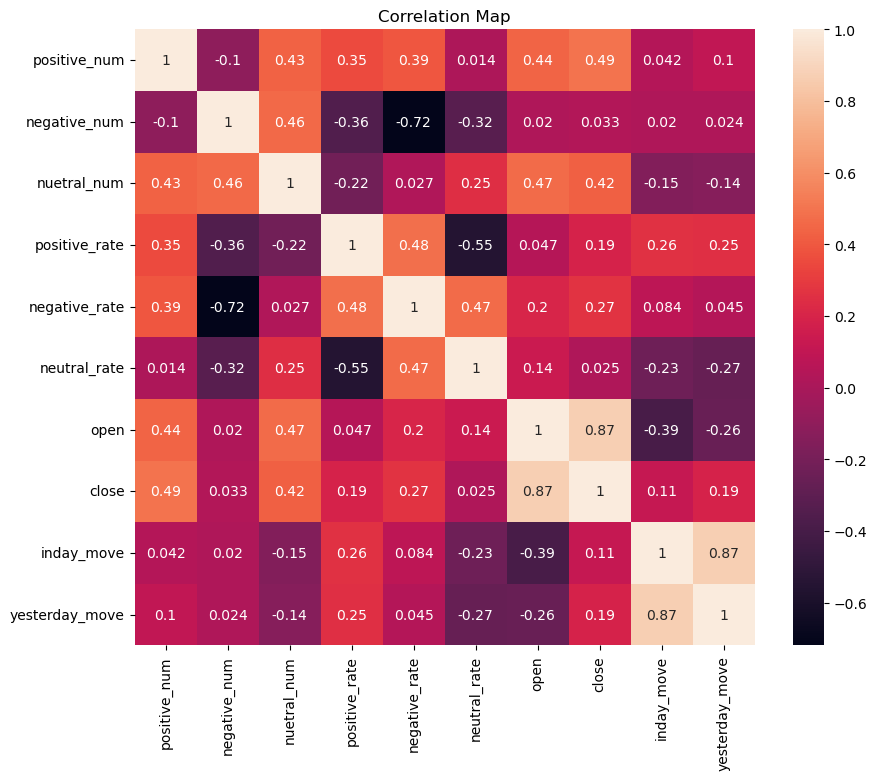

In [66]:
# check correlations first
corr_matrix = df.corr()

plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True)
plt.title('Correlation Map')
plt.show()

**Note:**
* Pearson correlation coefficient describes whether there is linear correlation between two parameters or not.
* From the heatmap, all stock price features are weak correlated with the news sentiment features.
* The max correlation is 0.49 netween positive news number and close price.

#### Check close price *VS* number of positive news

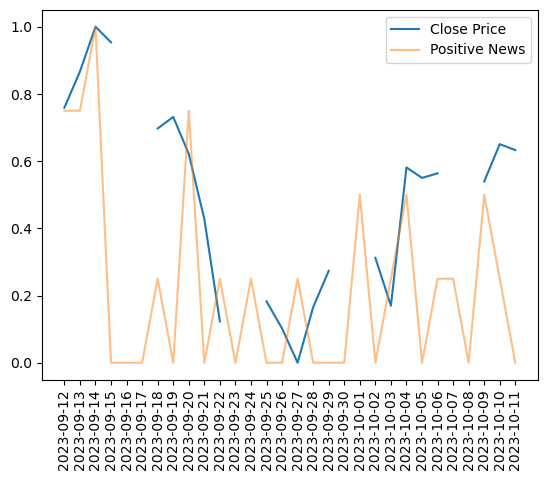

In [67]:
# first plot close data
plt.plot(df['date'], (df['close']-df['close'].min())/(df['close'].max()-df['close'].min()))
plt.plot(df['date'], (df['positive_num']-df['positive_num'].min())/(df['positive_num'].max()-df['positive_num'].min()), alpha = 0.5)
plt.legend(['Close Price', 'Positive News'])
plt.xticks(rotation = 90)
plt.show()

**Note:** There is no clear correlation between the close price and the positive news numbers.

#### Check dominant news sentiments (nuetral ignored) *VS* stock price move

In [69]:
# calcualte abosolute difference between positive and negative news number
df['pos_neg_diff'] = df['positive_num'] - df['negative_num']

C:\Users\wfei2\AppData\Local\Temp\ipykernel_21656\2861235874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pos_neg_diff'] = df['positive_num'] - df['negative_num']


In [106]:
df

,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate,open,close,inday_move,yesterday_move,pos_neg_diff,diff_past
0,2023-09-12,3,4,19,0.115385,-0.153846,0.730769,270.760,267.48,-3.280,-6.10,-1,NaN
1,2023-09-13,3,3,33,0.076923,-0.076923,0.846154,270.070,271.30,1.230,3.82,0,NaN
2,2023-09-14,4,9,12,0.160000,-0.360000,0.480000,271.320,276.04,4.720,4.74,-5,NaN
3,2023-09-15,0,10,8,0.000000,-0.555556,0.444444,277.550,274.39,-3.160,-1.65,-10,NaN
4,2023-09-16,0,0,2,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,0,NaN
5,2023-09-17,0,3,5,0.000000,-0.375000,0.625000,NaN,NaN,NaN,NaN,-3,NaN
6,2023-09-18,1,11,29,0.024390,-0.268293,0.707317,271.160,265.28,-5.880,-9.11,-10,NaN
7,2023-09-19,0,8,15,0.000000,-0.347826,0.652174,264.350,266.50,2.150,1.22,-8,NaN
8,2023-09-20,3,1,14,0.166667,-0.055556,0.777778,267.040,262.59,-4.450,-3.91,2,NaN
9,2023-09-21,0,3,5,0.000000,-0.375000,0.625000,257.850,255.70,-2.150,-6.89,-3,NaN


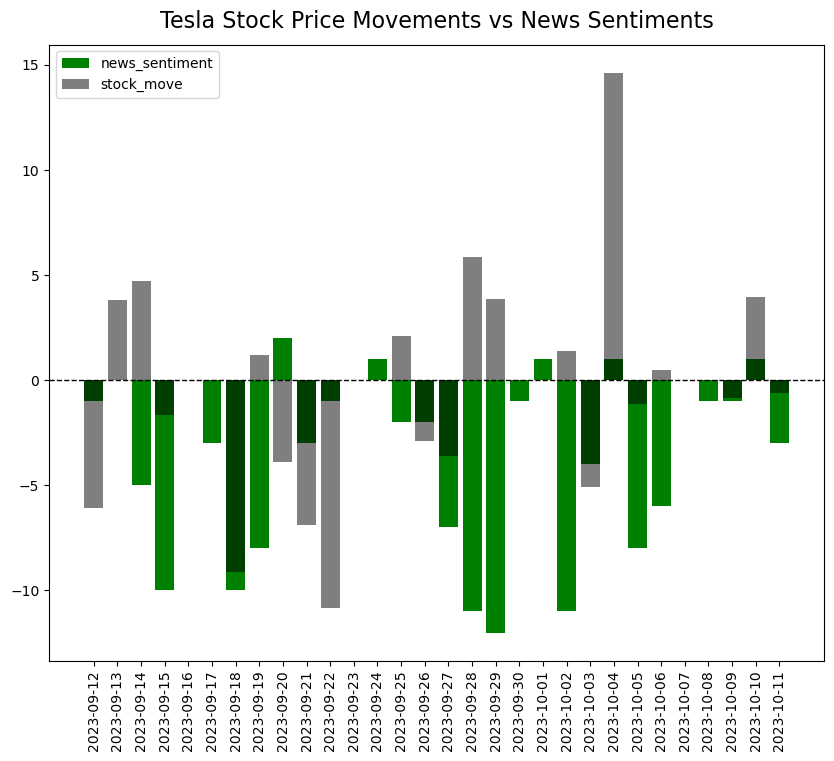

In [72]:
# create a bar plot to compared stock price change and news sentiments
plt.figure(figsize = (10, 8))
plt.bar(df['date'], df['pos_neg_diff'], color = 'g')
plt.bar(df['date'], df['yesterday_move'], color = 'k', alpha = 0.5)

plt.legend(['news_sentiment', 'stock_move'], loc = 'upper left')
plt.axhline(y = 0, color = 'k', linestyle = '--', linewidth = 1)
plt.xticks(df_combine['date'], rotation = 90)
plt.title('Tesla Stock Price Movements vs News Sentiments', fontsize = 16, pad = 12)

plt.show()

**Note:**
* If the news sentiments have clear impact on the stock prices. The stock price movements are expected to show same polarity (positive or negative) as the news_sentiment.
* There is no clear correlation between the stock price change and the sentiment results.
* Considering the possibility of delayed impact from news on stock prices, it is worth to combine the news sentiments and stock price movement from a period of time then check the bar plot again.

In [100]:
# define a function to plot averaged impact of news in the past
def get_plot(data, pastdays):
    data.loc[:,'diff_past'] = data['pos_neg_diff'].shift(1).rolling(window = pastdays).mean()
    plt.figure(figsize = (10, 8))
    plt.bar(data['date'], data['diff_past'], color = 'b')
    plt.bar(data['date'], data['close'].diff(pastdays), color = 'k', alpha = 0.5)
    plt.legend(['news_sentiment_period', 'stock_move'], loc = 'upper left')
    plt.axhline(y = 0, color = 'k', linestyle = '--', linewidth = 1)
    plt.title('Tesla Stock Price Movements vs News Sentiments (accumulated from the previous {}days)'.format(pastdays), fontsize = 16, pad = 12)
    plt.xticks(data['date'], rotation = 90)
    plt.show()

C:\Users\wfei2\AppData\Local\Temp\ipykernel_21656\370816152.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'diff_past'] = data['pos_neg_diff'].shift(1).rolling(window = pastdays).mean()


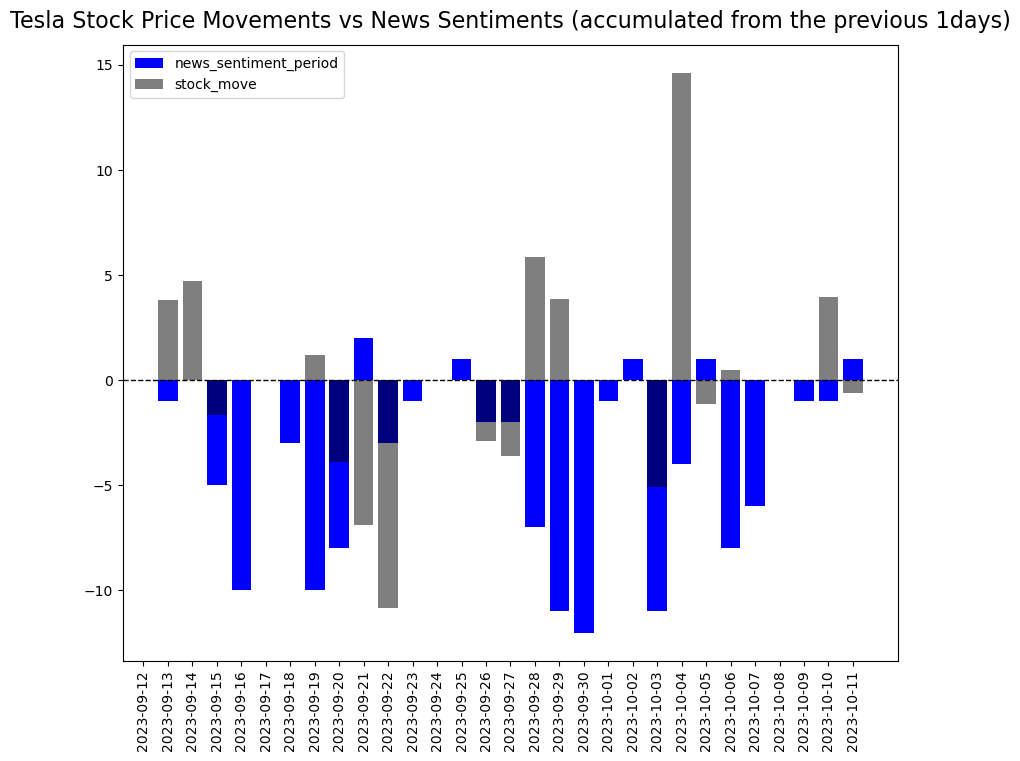

In [101]:
# let check impact from 1 day ago
get_plot(df, 1)

C:\Users\wfei2\AppData\Local\Temp\ipykernel_21656\370816152.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'diff_past'] = data['pos_neg_diff'].shift(1).rolling(window = pastdays).mean()


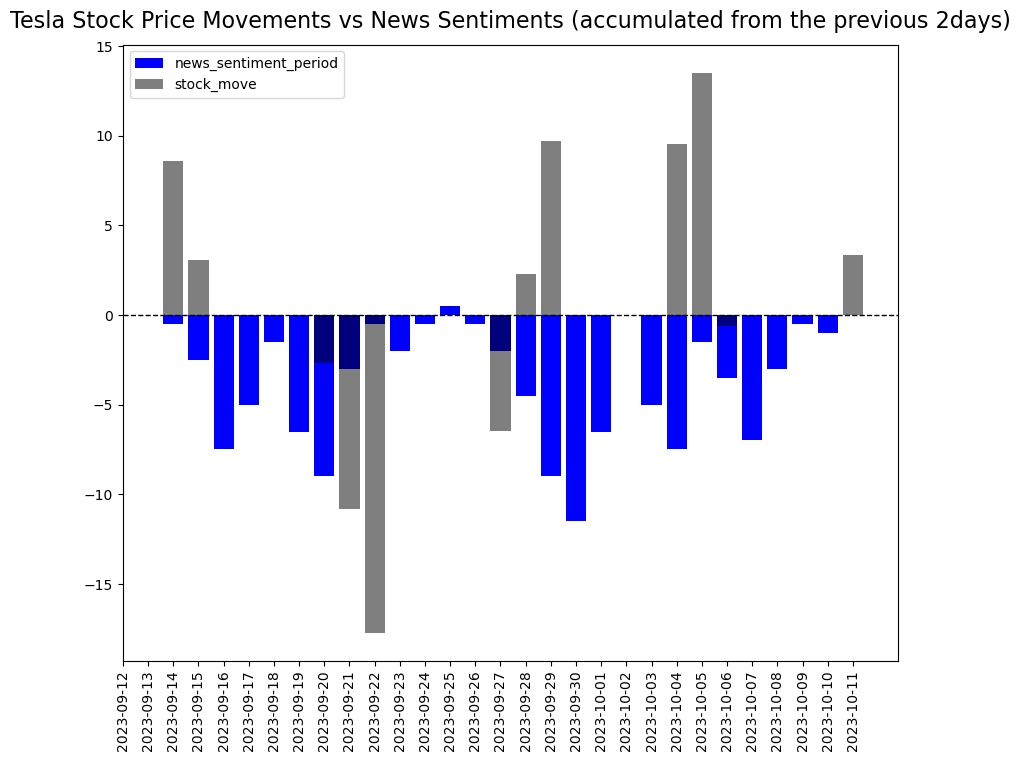

In [102]:
# let check impact from 2 days ago
get_plot(df, 2)

C:\Users\wfei2\AppData\Local\Temp\ipykernel_21656\370816152.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'diff_past'] = data['pos_neg_diff'].shift(1).rolling(window = pastdays).mean()


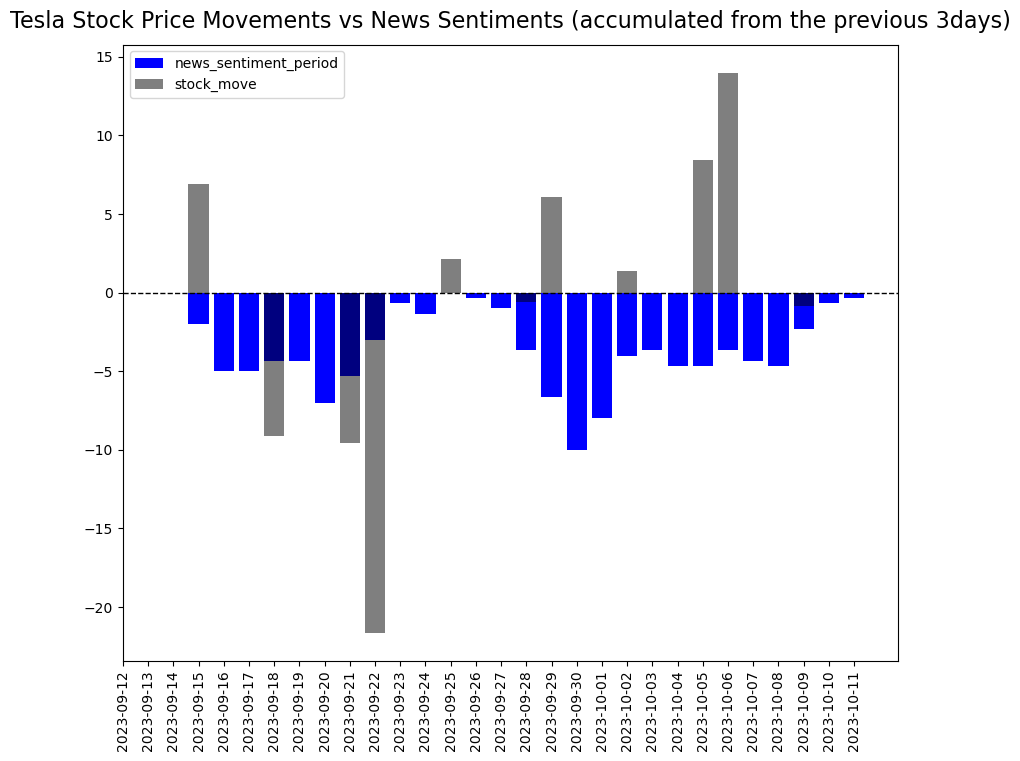

In [103]:
# let check impact from previous 3 days
get_plot(df, 3)

C:\Users\wfei2\AppData\Local\Temp\ipykernel_21656\370816152.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'diff_past'] = data['pos_neg_diff'].shift(1).rolling(window = pastdays).mean()


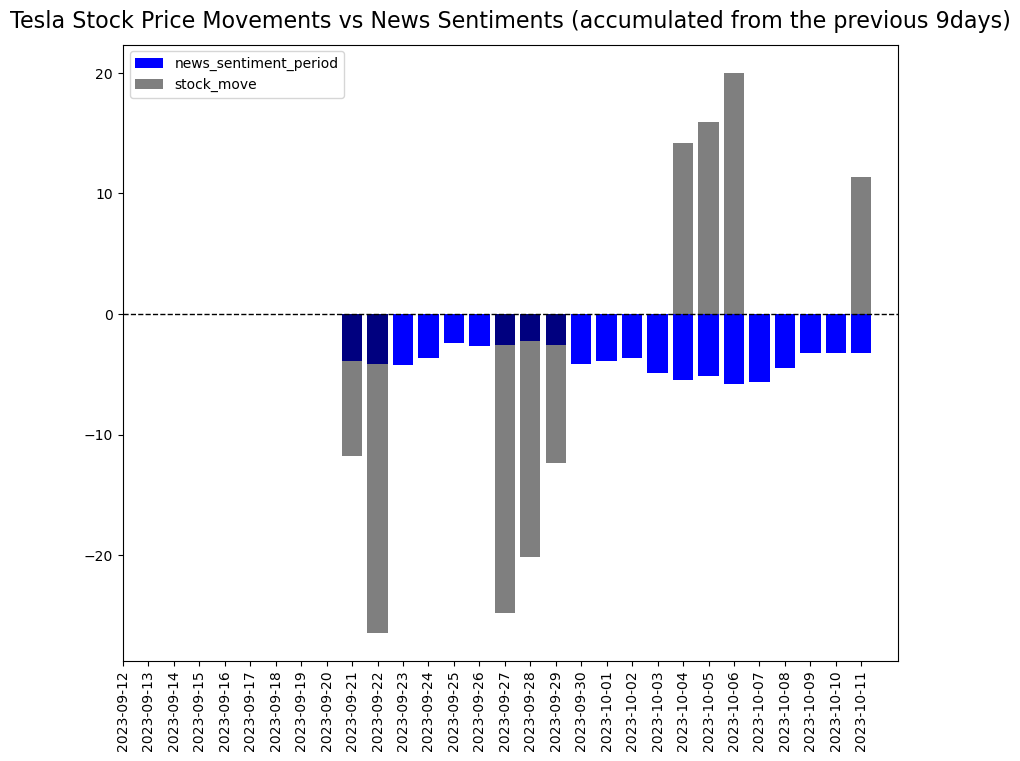

In [107]:
# let check impact from previous 9 days
get_plot(df, 9)

C:\Users\wfei2\AppData\Local\Temp\ipykernel_21656\370816152.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'diff_past'] = data['pos_neg_diff'].shift(1).rolling(window = pastdays).mean()


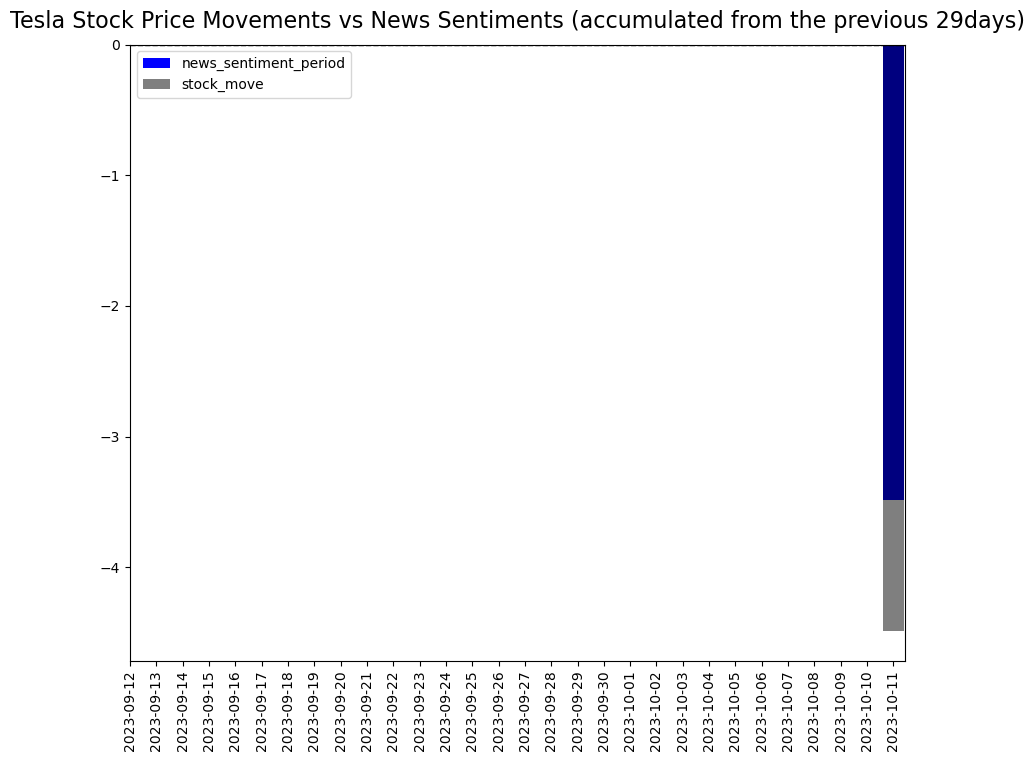

In [105]:
# let check impact from previous 29 days
get_plot(df, 29)

**Note:** 
* The stock price movements correlates with the previous-day news sentiment the best though quite some mis-match.
* The negative sentiments are exaggerated if averaging impact from previous days due to the fact that there are more negative news than positive ones in the past 30 days.
* Ignoring the neutral news and relying on the raw difference between positive and negative doesn't correlate well with the stock price movements.

## 2.4. Summary

**Observations:**
* Most of the news in the past 30 days were neutral to Tesla.
* Ignoring the neutral news, there were more negative news for Tesla in the past 30 days compared to positive ones.
* There is no clear strong correlation between the news sentiments and the stock market price movements.
* There is no solid short-term investigation strategies found through this work.
* In the past 30-day period, Tesla stock close price dropped and there were more negative news than positive ones. However, this is just an observation.

**What are not considered:**
* There are multiple and complex factors that will impact the stock price of a company. 
    * Market-related facors such as GDP, interest rates, inflation, employment rate, indicate how well the whole market is performing and they will have a signifcant impact on individual stocks. 
    * Company reports showing how the company performed in the past period of time is importance to its stock price. Earnings, dividens, debts, management qualities and etc. are key components to drive the stock price movement. 
    * Other factors such as global economy, regulations and goverment policies, industry-specific changes and natural disasters and pandemics all play a role here.

**How to improve:**
* Collecting data for a longer period of time to see if there is any long-term trend between the news sentiments and the stock price movement.
* Incoporate data from different sources, such as social media like Tweeter to see if the public sentiments can be better represented.
* Incorporate other factors mentioned in the not considered section.